In [4]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [5]:
# Add an additional column, mapping to the type
df = pd.read_csv('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

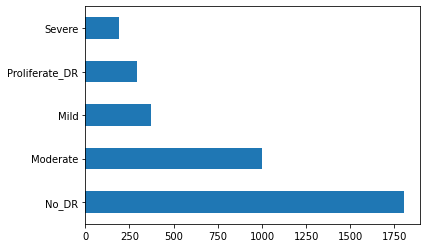

In [6]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

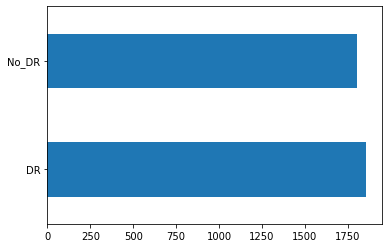

In [7]:
df['binary_type'].value_counts().plot(kind='barh')

In [8]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [9]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [10]:
# Copy images to respective working directory
src_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [11]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [12]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
81/81 [==============================] - 16s 109ms/step - loss: 0.3817 - acc: 0.8493 - val_loss: 0.7098 - val_acc: 0.5073
Epoch 2/30
81/81 [==============================] - 8s 101ms/step - loss: 0.2564 - acc: 0.9028 - val_loss: 0.8294 - val_acc: 0.5073
Epoch 3/30
81/81 [==============================] - 8s 99ms/step - loss: 0.2237 - acc: 0.9149 - val_loss: 0.9037 - val_acc: 0.5309
Epoch 4/30
81/81 [==============================] - 8s 99ms/step - loss: 0.2088 - acc: 0.9301 - val_loss: 0.7311 - val_acc: 0.5564
Epoch 5/30
81/81 [==============================] - 8s 98ms/step - loss: 0.1962 - acc: 0.9317 - val_loss: 0.5017 - val_acc: 0.6545
Epoch 6/30
81/81 [==============================] - 8s 101ms/step - loss: 0.1861 - acc: 0.9352 - val_loss: 0.2882 - val_acc: 0.8855
Epoch 7/30
81/81 [==============================] - 8s 95ms/step - loss: 0.1782 - acc: 0.9383 - val_loss: 0.2145 - val_acc: 0.9236
Epoch 8/30
81/81 [==============================] - 8s 101ms/step - loss: 0.170

In [13]:
model.save('eyenet_CNN.model')

In [14]:
# VGG16 Model
vgg_model = tf.keras.Sequential([
    tf.keras.applications.VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

vgg_model.layers[0].trainable = False  # Freeze VGG16 layers

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

vgg_history = vgg_model.fit(train_batches, 
                            validation_data=val_batches, 
                            epochs=30)

58900480/58889256 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
81/81 [==============================] - 13s 118ms/step - loss: 0.5489 - acc: 0.7576 - val_loss: 0.3844 - val_acc: 0.8836
Epoch 2/30
81/81 [==============================] - 8s 101ms/step - loss: 0.3638 - acc: 0.8852 - val_loss: 0.3091 - val_acc: 0.8855
Epoch 3/30
81/81 [==============================] - 8s 104ms/step - loss: 0.3173 - acc: 0.8950 - val_loss: 0.2837 - val_acc: 0.8982
Epoch 4/30
81/81 [==============================] - 9s 105ms/step - loss: 0.2955 - acc: 0.8981 - val_loss: 0.2696 - val_acc: 0.9091
Epoch 5/30
81/81 [==============================] - 8s 103ms/step - loss: 0.2820 - acc: 0.9059 - val_loss: 0.2588 - val_acc: 0.9073
Epoch 6/30
81/81 [==============================] - 9s 107ms/step - loss: 0.2689 - acc: 0.9102 - val_loss: 0.2534 - val_acc: 0.9091
Epoch 7/30
81/81 [==============================] - 9s 109ms/step - loss: 0.2581 - acc: 0.9145 - val_loss: 0.2467 - val_acc: 0.9109
Epoch 8/30
81/81 [==============================] - 9s 107ms/step - loss: 0

In [15]:
vgg_model.save('eyenet_vgg16.model')

In [16]:
# ResNet50 Model
resnet_model = tf.keras.Sequential([
    tf.keras.applications.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

resnet_model.layers[0].trainable = False  # Freeze ResNet50 layers

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

resnet_history = resnet_model.fit(train_batches, 
                                  validation_data=val_batches, 
                                  epochs=30)


94781440/94765736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
81/81 [==============================] - 13s 119ms/step - loss: 0.5149 - acc: 0.7970 - val_loss: 0.4206 - val_acc: 0.8582
Epoch 2/30
81/81 [==============================] - 9s 106ms/step - loss: 0.3914 - acc: 0.8649 - val_loss: 0.3740 - val_acc: 0.8636
Epoch 3/30
81/81 [==============================] - 9s 106ms/step - loss: 0.3494 - acc: 0.8720 - val_loss: 0.3493 - val_acc: 0.8673
Epoch 4/30
81/81 [==============================] - 9s 107ms/step - loss: 0.3248 - acc: 0.8790 - val_loss: 0.3349 - val_acc: 0.8673
Epoch 5/30
81/81 [==============================] - 9s 111ms/step - loss: 0.3143 - acc: 0.8888 - val_loss: 0.3253 - val_acc: 0.8727
Epoch 6/30
81/81 [==============================] - 9s 105ms/step - loss: 0.3049 - acc: 0.8841 - val_loss: 0.3154 - val_acc: 0.8764
Epoch 7/30
81/81 [==============================] - 8s 103ms/step - loss: 0.2996 - acc: 0.8833 - val_loss: 0.3085 - val_acc: 0.8782
Epoch 8/30
81/81 [==============================] - 9s 109ms/step - loss: 0

In [17]:
resnet_model.save('eyenet_resnet50.model')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:

loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("CNN test Accuracy: ", acc)

18/18 [==============================] - 1s 79ms/step - loss: 0.2287 - acc: 0.9200
CNN Accuracy:  0.9200000166893005
18/18 [==============================] - 2s 83ms/step - loss: 0.2385 - acc: 0.9109


In [21]:
loss, acc = vgg_model.evaluate_generator(test_batches, verbose=1)
print("vgg16 test Accuracy: ", acc)

18/18 [==============================] - 2s 79ms/step - loss: 0.2385 - acc: 0.9109
vgg16 test Accuracy:  0.910909116268158


In [23]:
loss, acc = resnet_model.evaluate_generator(test_batches, verbose=1)
print("resnet50 test Accuracy: ", acc)

18/18 [==============================] - 2s 82ms/step - loss: 0.3480 - acc: 0.8473
resnet50 test Accuracy:  0.8472727537155151


# ****Diabet Retinopathy Detection Section****

In [29]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("eyenet_resnet50.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

No DR


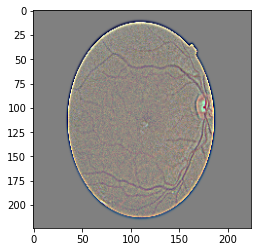

In [30]:
predict_class('/kaggle/working/test/No_DR/9be0683649ff.png')